In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from google.colab import files
uploaded = files.upload()



In [ ]:
# Load dataset
df = pd.read_csv("movie_reviews.csv")

# Keep only needed columns
df = df[['review', 'sentiment']].dropna()
df.columns = ['text', 'label']

# Map sentiment to 1 and 0
df['label'] = df['label'].map({'positive': 1, 'negative': 0})

# Preview data
df.head()


,text,label
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], stratify=df['label'], test_size=0.2, random_state=42
)


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
train_dataset = Dataset.from_dict({**train_encodings, 'label': list(train_labels)})
val_dataset = Dataset.from_dict({**val_encodings, 'label': list(val_labels)})


In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


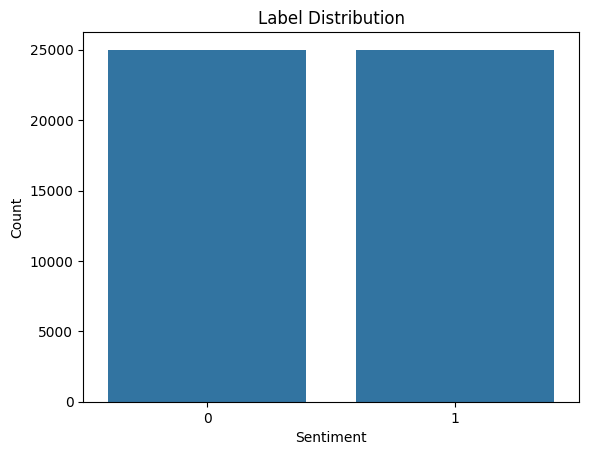

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=10,
    # add these if supported:
    logging_first_step=True,
    # disable evaluation if unsupported:
    # evaluation_strategy="no",
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()


In [ ]:
# Get predictions
preds = trainer.predict(val_dataset)
y_pred = preds.predictions.argmax(-1)
y_true = val_labels.tolist()

# Print results
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.9399
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5000
           1       0.93      0.95      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



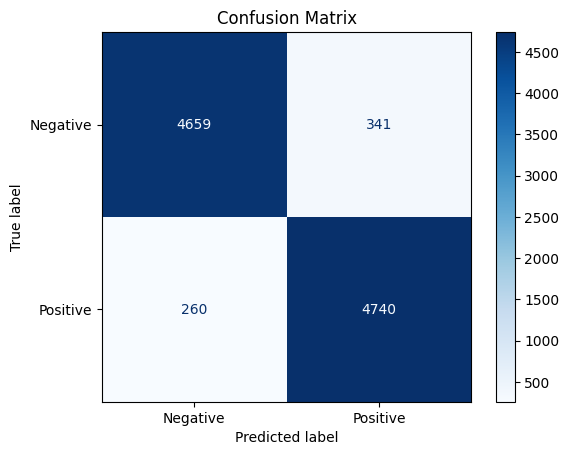

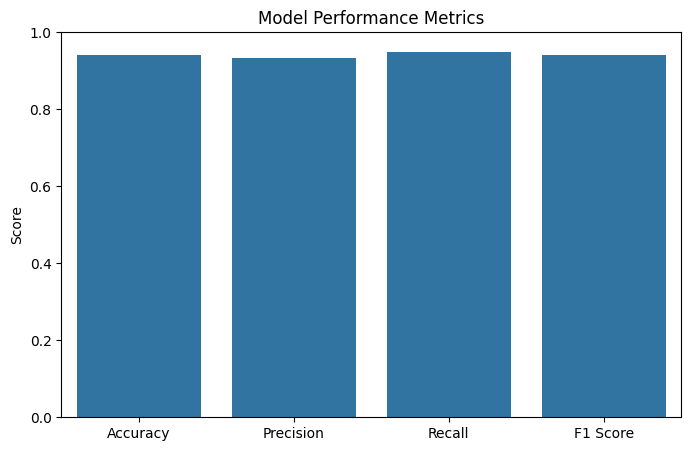

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt

# Actual and predicted labels
y_true = val_labels.tolist()
y_pred = preds.predictions.argmax(-1)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Bar Chart of Metrics
metrics = [accuracy, precision, recall, f1]
names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 5))
sns.barplot(x=names, y=metrics)
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.show()

